Here, we compute expected quantities for transformer wave functions

This includes 

 - 2nd Renyi entropy
 - correlation functions
 - local functions

In [24]:
import json
from TransformerWF import *
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

# Expectations

We'll estimate expectations in the same way we estimate energies:

\begin{equation}
    \langle \Psi | \hat{O} | \Psi \rangle = \sum_{\sigma, \sigma'} \psi_{\sigma'}^* \hat{O}_{\sigma', \sigma} \psi_{\sigma} = \sum_{\sigma, \sigma'} |\psi_{\sigma'}|^2 \hat{O}_{\sigma', \sigma} \frac{\psi_{\sigma}}{\psi_{\sigma'}}
\end{equation}

\begin{equation}
    V_{loc}(\sigma') = \sum_{\sigma} \hat{O}_{\sigma', \sigma} \frac{\psi_{\sigma}}{\psi_{\sigma'}}
\end{equation}

\begin{equation}
    \langle \Psi | \hat{O} | \Psi \rangle = \sum_{\sigma'} |\psi_{\sigma'}|^2 V_{loc}(\sigma')
\end{equation}

Therefore 

$$
\hat{O} = \sigma_x^i \sigma_x^j \implies \langle \sigma |\sigma_x^i \sigma_x^j = \langle \sigma_{(i, j)} |
$$
therefore
$$
V_{loc}(\sigma) = \frac{\psi_{\sigma_{(i, j)}}}{\psi_{\sigma}}
$$

In [15]:
def map_kink_to_state(kinks):
    """
    
    """
    batch_size=kinks.shape[0]
    configuration = [[1*(np.random.rand()>.5) for _ in range(batch_size)]]
    
    for idx in range(kinks.shape[-1]):
        next_step = []
        for bidx in range(batch_size):
            if kinks[bidx, idx]==0:
                next_step.append(configuration[idx][bidx])
            else:
                next_step.append(1-configuration[idx][bidx])
        configuration.append(next_step)

    configuration = np.array(configuration).T
    
    return configuration

In [16]:
def map_state_to_kink(state):
    """
    
    """
    kinks = []
    for idx in range(state.shape[-1]-1):
        kinks.append(
            1*(state[:, idx]!=state[:, idx+1])
        )
    
    return np.array(kinks).T

In [17]:
map_state_to_kink(map_kink_to_state(np.array([[1, 0],[1, 1]])))

array([[1, 0],
       [1, 1]])

In [56]:
def x_correlator(idx1, idx2, sample_size, decoder, include_phases=False, kink=True):
    """
    
    """
    if idx1==idx2:
        return 1
    
    # to avoid overloading the memory
    max_batch_size = 15_000
    count = sample_size
    
    correlator = 0
    
    while count>0:
        batch_size = min(max_batch_size, count)
        count -= batch_size
        
        initial_states = np.zeros((batch_size, 1))

        samples, log_probs, phases = decoder.autoregressive_sampling(
            initial_states
        )
        
        if kink:
            samples = map_kink_to_state(samples)
        
        # Obtain the flipped states
        flip_array = np.ones_like(samples)
        flip_array[:, idx1] = -1
        flip_array[:, idx2] = -1
        
        flipped_samples = ((2*samples-1)*flip_array+1)/2
        
        if kink:
            flipped_samples = map_state_to_kink(flipped_samples)
            
        flipped_log_probs, flipped_phases = decoder.evaluate_state(
            flipped_samples,
        )
        
        ratio_mags = tf.math.exp(
            (1/2)*(flipped_log_probs - log_probs)
        )
        
        if include_phases:
            ratio_real_part = ratio_mags*tf.math.cos(-phases + flipped_phases)
            # ratio_imag_part = ratio_mags*tf.math.sin(-phases + flipped_phases)
        else:
            ratio_real_part = ratio_mags
        
        # we only care about the real part
        correlator += np.sum(ratio_real_part.numpy())
    
    return correlator/sample_size

In [50]:
xs = [x_correlator(0, idx, sample_size=10_000, decoder=decoder) for idx in range(80)]

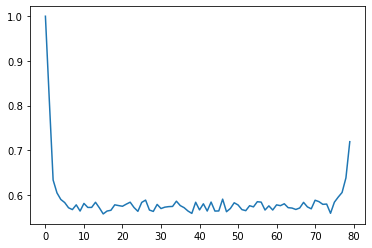

In [51]:
plt.plot(xs)

In [52]:
x_expectation(50, sample_size=10_000, decoder=decoder, include_phases=False)

0.682384521484375

In [26]:
x_correlator(0, 50, sample_size=10_000, decoder=decoder, include_phases=False)

0.5102296569824218

In [27]:
x_correlator(0, 50, sample_size=10_000, decoder=decoder, include_phases=False)

0.5258552642822265

In [44]:
out = z_correlator(sample_size=10_000, decoder=decoder, include_phases=False)

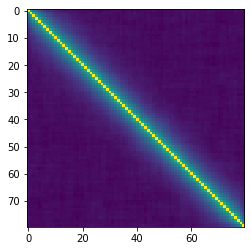

In [45]:
plt.imshow(out, interpolation='nearest')

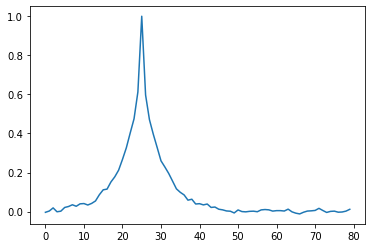

In [47]:
plt.plot(out[25, :])

In [19]:
def x_expectation(idx, sample_size, decoder, include_phases=True, kink=True):
    """
    
    """
    
    # to avoid overloading the memory
    max_batch_size = 15_000
    count = sample_size
    
    expectation = 0
    
    while count>0:
        batch_size = min(max_batch_size, count)
        count -= batch_size
        
        initial_states = np.zeros((batch_size, 1))

        samples, log_probs, phases = decoder.autoregressive_sampling(
            initial_states
        )
        
        if kink:
            samples = map_kink_to_state(samples)
        
        # Obtain the flipped states
        flip_array = np.ones_like(samples)
        flip_array[:, idx] = -1
        
        flipped_samples = ((2*samples-1)*flip_array+1)/2
        
        if kink:
            flipped_samples = map_state_to_kink(flipped_samples)
            
        flipped_log_probs, flipped_phases = decoder.evaluate_state(
            flipped_samples,
        )
        
        ratio_mags = tf.math.exp(
            (1/2)*(flipped_log_probs - log_probs)
        )
        
        if include_phases:
            ratio_real_part = ratio_mags*tf.math.cos(-phases + flipped_phases)
            # ratio_imag_part = ratio_mags*tf.math.sin(-phases + flipped_phases)
        else:
            ratio_real_part = ratio_mags
        
        # we only care about the real part
        expectation += np.sum(ratio_real_part.numpy())
    
    return expectation/sample_size

In [47]:
decoder.sequence_length-1

100

In [43]:
def z_correlator(sample_size, decoder, include_phases=True, kink=True):
    """
    
    """
    #if idx1==idx2:
    #    return 1
    
    # to avoid overloading the memory
    max_batch_size = 15_000
    count = sample_size
    
    length = decoder.sequence_length-1
    
    if kink:
        correlations = np.zeros((length+1, length+1))
    else:
        correlations = np.zeros((length, length))
    
    while count>0:
        batch_size = min(max_batch_size, count)
        count -= batch_size
        
        initial_states = np.zeros((batch_size, 1))

        samples, log_probs, phases = decoder.autoregressive_sampling(
            initial_states
        )
        
        if kink:
            samples = map_kink_to_state(samples)
        
        # compute correlator
        
        inner = np.einsum("bi,bj->ij", 2*samples-1, 2*samples-1)
        
        correlations += inner
        
        """spins1 = 2*samples[:, idx1]-1
        spins2 = 2*samples[:, idx2]-1
        
        correlator += np.sum(spins1*spins2)"""
    
    return correlations/sample_size

In [5]:
def z_expectation(idx, sample_size, decoder, include_phases=True, kink=True):
    """
    
    """
    if kink:
        return 0
    
    # to avoid overloading the memory
    max_batch_size = 15_000
    count = sample_size
    
    correlator = 0
    
    while count>0:
        batch_size = min(max_batch_size, count)
        count -= batch_size
        
        initial_states = np.zeros((batch_size, 1))

        samples, log_probs, phases = decoder.autoregressive_sampling(
            initial_states
        )
        
        # compute correlator
        
        spins = 1-2*samples[:, idx]
        
        correlator += np.sum(spins)
    
    return correlator/sample_size

# creating and saving data

Now we'll compute these expectations

In [25]:

name = "kink_modified_training_length_80_tfim_seed_3"

In [26]:
with open(f'params_{name}.json', 'r') as param_file:
    params=json.loads(param_file.read())

print(params)

{'num_heads': 2, 'key_dim': 15, 'value_dim': 15, 'embedding_dim': 15, 'dictionary_size': 2, 'decoding_reps': 2, 'width': None, 'depth': 2, 'sequence_length': 80}


In [27]:
decoder=TransformerDecoder(
    **params
)

In [28]:
decoder.load_weights(name)

Now that weights are loaded, we can compute the quantities and save them for the transformer wavefunction

## Correlations
$$
\langle S^x_1 S^x_n \rangle
$$

$$
\langle S^z_1 S^z_n \rangle
$$

In [57]:
sample_size = 150_000

xx_correlators = []
for idx in range(80):
    print(idx)
    xx_correlators.append(x_correlator(0, idx, sample_size, decoder))

np.save(f"{name}_xx_correlators", xx_correlators)

zz_correlators = z_correlator(sample_size, decoder)

np.save(f"{name}_zz_correlators", zz_correlators)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [ ]:
plt.plot(xx_correlators)

In [58]:
sample_size = 150_000

xx_correlators25 = []
for idx in range(80):
    xx_correlators25.append(x_correlator(24, idx, sample_size, decoder))

np.save(f"{name}_xx_correlators25", xx_correlators25)

zz_correlators25 = []
for idx in range(decoder.sequence_length-1):
    zz_correlators25.append(z_correlator(24, idx, sample_size, decoder))

np.save(f"{name}_zz_correlators25", zz_correlators25)

'    \nzz_correlators25 = []\nfor idx in range(decoder.sequence_length-1):\n    zz_correlators25.append(z_correlator(24, idx, sample_size, decoder))\n\nnp.save(f"{name}_zz_correlators25", zz_correlators25)'

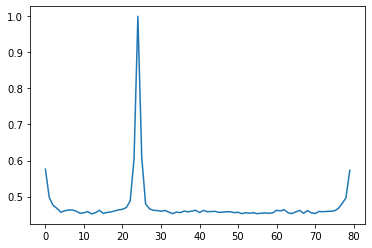

In [63]:
plt.plot(xx_correlators25)

## Expectations

$$
\langle S^x_n \rangle
$$

$$
\langle S^z_n \rangle
$$

In [59]:
sample_size = 150_000

x_expectations = []
for idx in range(80):
    print(idx)
    x_expectations.append(x_expectation(idx, sample_size, decoder))

np.save(f"{name}_x_expectations", x_expectations)


z_expectations = []
for idx in range(1, decoder.sequence_length-1):
    z_expectations.append(z_expectation(idx, sample_size, decoder))

np.save(f"{name}_z_expectations", z_expectations)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


'\nz_expectations = []\nfor idx in range(1, decoder.sequence_length-1):\n    z_expectations.append(z_expectation(idx, sample_size, decoder))\n\nnp.save(f"{name}_z_expectations", z_expectations)\n'

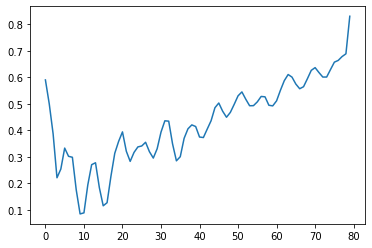

In [60]:
plt.plot(x_expectations)

In [62]:
plt.plot(xx_correlations)

NameError: name 'xx_correlations' is not defined

In [18]:
import matplotlib.pyplot as plt

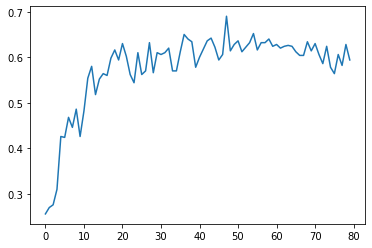

In [19]:
plt.plot(z_expectations)

## 2-Renyi's

Now lets sweep across regions

In [ ]:
second_renyis = []

for idx in range(1, decoder.sequence_length-1)
    trace = compute_nth_renyi(
        n=2,
        batch_size=100,
        region=(0,idx),
        reps=150
    )
    
    second_renyis.append(
        -np.log(trace)
    )

In [ ]:
np.save(f"{name}_second_renyis", second_renyis)